# Рекомендательная система фильмов на данных MovieLens

Выполнил Алескин Александр, 317 группа

In [1]:
import sys
import numpy as np
import scipy as sp
import scipy.sparse 
import scipy.sparse.linalg
import pandas as pd
from mrjob.job import MRJob
import matplotlib.pyplot as plt
import time
import json
from  IPython.display import HTML as html
import requests, zipfile, StringIO

%matplotlib inline

Загрузим файлы:

In [2]:
req = requests.get('http://files.grouplens.org/datasets/movielens/ml-1m.zip', stream=True)
archive = zipfile.ZipFile(StringIO.StringIO(req.content))
print 'paths ', archive.namelist()

# ознакомимся с Readme
# print '\nREADME\n', archive.open('ml-1m/README').read()

paths  ['ml-1m/', 'ml-1m/movies.dat', 'ml-1m/ratings.dat', 'ml-1m/README', 'ml-1m/users.dat']


## 1. Content-based модель

Так как в данном пункте не предполагается использования библиотеки mrjob, то преобразуем в удобный формат данные, преобразуем данные (выполняет fit_transform) и разобьем на обучающую и тестовую выборку:

In [19]:
def fit_transform(ratings, users, movies):
    
    scores = (ratings[:, 2]) / 5.0

    # итак, посчитаем количество признаков:
    #    от пользователя: 2 - пол, 7 - возраст, 21 - профессия 1 - с.р. пользователя, всего: 31
    #    от фильма: 1 - средний рейтинг фильма, 18 - Жанр, 9 - год выпуска(по десятилетиям),
    #               1 - количество жанров, всего 29
    #    от оценок: 1 - корреляция взглядов,   всего: 1
    # итого : 31 + 29 + 1 + 1(константный признак)= 62
    u = 31
    m = 29 # при изменение возможно надо будет ниже поменять еще что-нибудь
    n = u + m + 2

    # определим функцию, возвращающая номер позиции для категориального признака:
    def get_position(dictionary, key):
        try:
            pos = dictionary[key]
        except KeyError:
            pos = len(dictionary)
            dictionary[key] = pos
        return pos

    X = np.zeros((ratings.shape[0], n))

    # так и так придеться делать перебором, причем умным перебором не факт что ускорение будет значительным
    # поэтому влоб в 2 этапа:

    # movies
    movies2 = np.zeros((movies.shape[0], m))
    map_movie_genre = {}
    map_movie_year = {}

    for i in range(movies.shape[0]):
        # score
        j = np.where(ratings[:, 1] == int(movies[i, 0]))[0]
        if len(j) > 0:
            movies2[i, 0] = scores[j].mean()

            # year
            offset = 1
            title = movies[i, 1]
            sd = title.find('(19')
            if sd == -1:
                sd = title.find('(20')
            year = title[sd + 1:sd + 4]
            pos = get_position(map_movie_year, year) 
            movies2[i, pos + offset] = 1

            # genre
            offset = 10
            genres = movies[i,2].split('|')
            for genre in genres:
                pos = get_position(map_movie_genre, genre)
                movies2[i, pos + offset] = 1
            # amount of genres
            movies2[i: , -1] = len(genres)

    # users
    users2 = np.zeros((users.shape[0], u + 18))
    map_user_age = {}
    map_user_prof = {}

    for i in range(users.shape[0]):
        # score
        j = np.where(ratings[:, 0] == int(users[i, 0]))[0]
        if len(j) > 0:
            users2[i, 0] = scores[j].mean()

            # sex
            if users[i, 1] == 'M':
                users2[i, 1] = 1
            else:
                users2[i, 2] = 1

            #age
            offset = 3
            pos = get_position(map_user_age, users[i, 2])
            users2[i, pos + offset] = 1

            # profession
            offset += 7
            pos = get_position(map_user_prof, users[i, 3])
            users2[i, pos + offset] = 1

            # special 
            offset += 21
            gen_scores = np.zeros(18)
            gen_sc_amount = np.zeros(18)
            for mv in range(len(j)):
                gen = movies2[np.where(movies[:, 0] == ratings[j[mv], 1])[0]][0, -19:-1]
                gen_sc_amount += gen
                gen_scores += gen * scores[j[mv]]
            users2[i, offset:] = gen_scores / (gen_sc_amount + 1e-4)

    # 2nd step
    X[:, -1] = 1 # constant for regression task
    for i in range(ratings.shape[0]):
        user = users2[np.where(users[:, 0] == ratings[i, 0])[0]][0]
        movie = movies2[np.where(movies[:, 0] == ratings[i, 1])[0]][0]
        X[i, :u] = user[:u]
        X[i, u:-2] = movie
        X[i, -2] = user[u:].dot(movie[10:-1].T) / movie[-1] 
    return X, scores

In [20]:
users = pd.read_csv(StringIO.StringIO(archive.open('ml-1m/users.dat').read()),
                    sep='::', header=None, engine='python').values
ratings = pd.read_csv(StringIO.StringIO(archive.open('ml-1m/ratings.dat').read()),
                      sep='::', header=None, engine='python').values
movies = pd.read_csv(StringIO.StringIO(archive.open('ml-1m/movies.dat').read()),
                     sep='::', header=None, engine='python').values

time_for_transform = - time.time()
X, scores = fit_transform(ratings, users, movies)
time_for_transform += time.time()

ind = np.argsort(ratings[:, 3])
X = X[ind]
y = scores[ind]
l = int(y.shape[0] * 0.8)
X_train = X[:l]
X_test = X[l:]
y_train = y[:l]
y_test = y[l:]


В качестве 2 дополнительных признаков были взяты год фильма и количество жанров у фильма.

Так как рейтинг ищем как линейную комбинацию признаков, то для подбора весов воспользуемся Ridge-регресии: 
$$ || Xw - y ||^2 + \lambda||w||^2  \to min$$
Тогда оптимальное значения для весов можно искать как решение следующей СЛАУ:
$$ (X^TX + \lambda I) w = X^T y $$

Реализуем вычисления, добавив возможность поиска оптимального параметра:

In [21]:
def compute_content(X_train, y_train, a=0.2, Search=False, X_test=None, y_test=None):
    if Search: 
        if (X_test is None) or (y_test is None):
            raise ValueError('enter X_test and y_test')
        if type(a) == float or type(a) == int:
            a = [a]
        scores = np.zeros(len(a))
        for i in range(len(a)):
            w = np.linalg.solve(X_train.T.dot(X_train) + a[i] * np.eye(X_train.shape[1]), X_train.T.dot(y_train))
            scores[i] = ((y_test - X_test.dot(w)) ** 2).sum() / y_test.shape[0]
        return scores
    else:
        return np.linalg.solve(X_train.T.dot(X_train) + a * np.eye(X_train.shape[1]), X_train.T.dot(y_train))

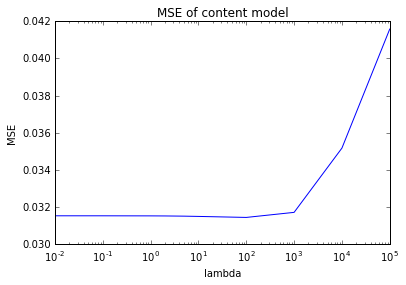

In [30]:
lams = np.array([0.01, 0.1, 1, 2, 5, 10, 100, 1e3, 1e4, 1e5])
scores = compute_content(X_train, y_train, lams, True, X_test, y_test)
plt.xscale('log')
plt.plot(lams, scores)
plt.title('MSE of content model')
plt.xlabel('lambda')
plt.ylabel('MSE')

Как видно результат не сильно зависит от параметра. Оптимальное значение при $ \lambda = 100 $. Вероятная причина -- задача хорошо аппроксимируется линейной моделью.

Оценим точность и время работы(c учетом преобразования признаков) алгоритма:

In [98]:
comp = -time.time()
w = compute_content(X_train, y_train, 100)
comp += time.time()
score = ((y_test - X_test.dot(w)) ** 2).sum() / y_test.shape[0]
print 'best score is ', score, ' . Total time ', comp + time_for_transform, ' s, \n where transform compute ',\
        time_for_transform / (comp + time_for_transform), '% of all time.'
print 'regression computes in ', comp, ' s.'

best score is  0.0314542961354  . Total time  307.012928963  s, 
 where transform compute  0.999648558634 % of all time.
regression computes in  0.107897043228  s.


Почти все время уходит на преобразование данных. Такое долгое преобразование связано с тем, что приходиться поэлементо работать, а так же выделять из строк данные.

## 2. Neighborhood based

В данном подходе определяют меру adjusted cosine similarity похожести фильмов i и j как векторов в пространстве пользователей:
    $$ sim(i, j) = \frac{\sum_{u \in U} (r_{u, i} - \overline{r_u}) (r_{u, j} - \overline{r_u})}{ \sqrt{\sum_{u \in U} (r_{u, i} - \overline{r_u})^2} \sqrt{\sum_{u \in U} (r_{u, j} - \overline{r_u})^2} }$$
    

где $U$ – множество пользователей, которые оценили фильмы $i$ и $j$, $\overline{r_u}$ – средний рейтинг пользователя u.

Рейтинги для неизвестных фильмов считаются по следующей формуле:

$$ \hat{r}_{u, i} = \frac{\sum_{j : r_{u, j} \neq 0} sim(i, j) r_{u, j}} {\sum_{j : r_{u, j} \neq 0} sim(i, j)} $$

Такой подход называется item-oriented. его и будем реализовывать. Однако, существует аналогичный метод user-oriented, где сравнивается сами пользователи. В таком варианте формулы остаються почти без изменений:

$$ sim(u, w) = \frac{\sum_{i \in M} (r_{u, i} - \overline{r_i}) (r_{w, i} - \overline{r_i})}{ \sqrt{\sum_{i \in M} (r_{u, i} - \overline{r_i})^2} \sqrt{\sum_{i \in M} (r_{w, i} - \overline{r_i})^2} }$$

где $M$ – множество фильмов, которые оценили пользователи $u$ и $m$, $\overline{r_i}$ – средний рейтинг фильма $i$.

$$ \hat{r}_{u, i} = \frac{\sum_{w : r_{w, i} \neq 0} sim(u, w) r_{w, i}} {\sum_{w : r_{w, i} \neq 0} sim(u, w)} $$


Так как задание предполагается выполнить в парадигме map-reduce, то дабы не усложнять код, опишем класс для запуска в отдельном файле runner.py, листинг которого приведен ниже:
```python

class Neighborhood(MRJob):
    def steps(self):
        return [
                    MRStep(mapper=self.user_rating, reducer= self.user_count),
                    MRStep(mapper=self.remix, reducer = self.similarity),
                    MRStep(mapper=self.pseudo_matrix, reducer=self.save_matrix)
               ]

    def user_rating(self, key, line):
        user_id, movie_id, rate, time = line.split(',')
        yield user_id, (movie_id, rate)

    def user_count(self, user_id, values):
        user_rates = 0
        user_mean = 0
        final = []
        for movie_id, rate in values:
            r = float(rate) # / 5
            user_rates += 1
            user_mean += r
            final.append([int(movie_id), r])

        user_mean /= (user_rates + 1e-5)
        for i in range(len(final)):
            final[i][1] -= user_mean

        yield user_id, final

    def remix(self, user_id, values):
        for item1, item2 in combinations(values, 2):
            yield (item1[0], item2[0]), (item1[1], item2[1])

    def similarity(self, pair_id, rates):
        sum_x = 0
        sum_y = 0
        sum_xy = 0
        for rate_x, rate_y in rates:
            sum_x += rate_x ** 2
            sum_y += rate_y ** 2
            sum_xy += rate_x * rate_y
        simila = sum_xy / (np.sqrt(sum_x) * np.sqrt(sum_y))
        if simila < eps:
            simila = 0
        yield pair_id, simila

    def pseudo_matrix(self, pair_id, simila):
        pair = pair_id
        sim = simila
        yield pair[0], (pair[1], sim)
        yield pair[1], (pair[0], sim)

    def save_matrix(self, movie_id, relate_movie):
        related = []
        for item in relate_movie:
            related.append(item)
        related.sort(key= lambda x: x[1], reverse=True)
        yield movie_id, related


if __name__ == '__main__':
    Neighborhood.run()
```

преобразуем входные данные:

In [354]:
ratings = pd.read_csv(StringIO.StringIO(archive.open('ml-1m/ratings.dat').read()),
                      sep='::', header=None, engine='python')
ratings2 = {}
for r in ratings.values:
    try:
        ratings2[r[0]].append(r[1:])
    except KeyError:
        ratings2[r[0]] = [r[1:]]

        train_frac = 0.8
train = []
test = []
for u, itemList in ratings2.items():
    # itemList = [(i, r, t), ...]
    all = sorted(itemList, key=lambda x: x[2])
    thr = int((len(all) * train_frac))
    train.extend(map(lambda x: (u, x[0], x[1] / 5.0), all[:thr]))
    test.extend(map(lambda x: (u, x[0], x[1] / 5.0), all[thr:]))
    
train = np.array(train)
train[:, :2] -= 1
test = np.array(test)
test[:, :2] -= 1
print("ratings in train:", len(train))
print("ratings in test:", len(test)) 
rate_train = pd.DataFrame(train)
rate_train.iloc[:, 1] = np.int32(rate_train.iloc[:, 1].values)
rate_train.to_csv('ratings.dat', sep=',', index=False, header=False)

('ratings in train:', 797758)
('ratings in test:', 202451)


Запустим mrjob через терминал:

In [376]:
fit_time = -time.time()
!python runner.py  ratings.dat -r local —jobconf mapred.map.tasks=3 —jobconf mapred.reduce.tasks=3   >out.dat
fit_time += time.time()
print 'time for learning ', fit_time

time for learning  863.294950008


Для удобной работы с полученной матрицей близости и упрощения исследований опишем соответствующие функции:

In [370]:
def get_cov(path, N=50, M = 3952):
    f = open(path)
    lines = f.readlines()
    lines = [line.split('\t') for line in lines]
    C = np.zeros((M, M))
    for line in lines:
        vals = np.array(json.loads(line[1]))[:N ]
        try:
            C[int(line[0]), np.int32(vals[:, 0])] = vals[:, 1]
        except IndexError:
            pass
    return C

def count_score(rate_test, rate_train, C, U = 6040, M = 3952):
    eps=1e-6
    submited = sp.sparse.csr_matrix((rate_train[:, 2], (rate_train[:,0], rate_train[:,1])), shape=(U, M))
    submited = submited.toarray()
    #submited_bool = np.int32(submited > 0)
    #mvs = np.int32(rate_test.values[:, 1])
    #usrs = np.int32(rate_test.values[:, 0])
    errs = np.zeros(rate_test.shape[0])
    for i in range(rate_test.shape[0]):
        x = submited[int(rate_test[i, 0])]
        j = np.where(x)[0]
        if len(j) > 0:
            x = x[j]
            C_c = C[int(rate_test[i, 1])][j]
            errs[i] = C_c.dot(x) / (eps + np.sum(C_c))
        else:
            errs[i] = 0.6
    return np.sum((errs - rate_test[:, 2]) ** 2) / errs.shape[0]

Исследуем как зависит скорость вычислений и точность от количества сохраняемых похожих элементов в матрице:

In [378]:
Ns = np.array([10, 25, 50, 100, 250, 500, 1000, 2500])
results = np.zeros((Ns.size, 3))
for i in range(Ns.size):
    start = time.time()
    C = get_cov('out.dat', N=Ns[i])
    results[i, 1] = count_score(test, train, C)
    results[i, 2] = time.time() - start + fit_time
    results[i, 0] = count_score(train, train, C)

res = pd.DataFrame(np.hstack((Ns[np.newaxis].T, results)),
                   columns=['N', 'MSE train data', 'MSE test data', 'Time, s'])
res['Time, s'] -=fit_time
html(res.to_html(index=False))

N,MSE train data,MSE test data,"Time, s"
10.0,0.549536,0.495164,21.875653
25.0,0.536983,0.477071,22.118435
50.0,0.520336,0.455025,21.967035
100.0,0.462529,0.411446,21.796632
250.0,0.165385,0.184282,21.899953
500.0,0.036413,0.056640,22.336408
1000.0,0.024641,0.035954,20.652716
2500.0,0.025303,0.035114,20.717383


Такая плохая точность при N < 100 обесняется тем, что пользователь мог не оценить фильмы, которые сильно коррелирует с данным. Поэтому для приемлимой точности надо брать N > 500. 

Почти одинаковое время для выполнения для любого N связано с тем, что используются матричные вычисления для полных матриц(использование разреженных матриц замедляет вычисления). Небольшая вариация связана с возможным паралелльным использованием ноутбука в других целях. 

Общее вермя алгоритма с учетом обучения составляет примерно 14.7 минуты.

## 3. Latent factor based

В данном подходе оценка представляется как скалярное произведение векторов $ p_u , q_i \in R^k $:
$$ r_{u, i} = p_u^T q_i $$

Для настройки модели минимизируем следующий функционал:

$$ \sum_{u, i, r_{u, i}} [(r_{u, i} - p_u^T q_i) ^ 2  + \lambda_p p_u^T p_u + \lambda_q q_i^T t_i ] $$

где суммирование ведется по всем тройкам выборки $ u, i, r_{u, i} $.

Будем пользоваться пошаговым методом оптимизации ALS. Пусть даны некоторые приближения матрицы $ P \in R^{|u| \times K}, Q \in R^{|i| \times K} $, характеризующие пользователей и фильмы. Матрицей $ Q[u] \in R^{n_u \dot K}$ будем обозначать подматрицу матрицы $Q$ только для фильмов, оцененных пользователем $u$, где $n_u$ – количество оценок пользователя $u$.
В методе проводятся $N$ итераций, в рамках каждой итерации сначала оптимизируется $P $при фиксированном
$Q$, затем $Q$ при фиксированном $P$.
Шаг перенастройки $p_u$ при фиксированной матрице $Q$ сводится к настройке ridge-регрессии и выглядит так:

$$ A_u = Q[u]^T Q[u] $$
$$ d_u = Q[u]^T r_u $$
$$ p_u = (\lambda_p n_u I + A_u)^{−1}d_u $$

Аналогично выглядит перенастройка для фильмов(через $ P[i] $ аналогично с $ Q[u] $ обозначается подматрица $ P $ пользователей, которые оценили данный фильм):

$$ B_i = P[i]^T P[i] $$
$$ d_i = P[i]^T r_i $$
$$ q_i = (\lambda_q n_i I + B_i)^{−1}d_i $$


опишем функцию реализующий минимизацию функционала:

In [231]:
def latent(X_train, a_p = 0.2, a_q = 0.001, N = 20, K =10):
    """
    params:
    X_train: array with shape(|U| , |M|), where |U| - amount of users, |M| - amount of movies
    a_p: parameter for 2nd summand 
    a_q: parameter for 3th summand
    N: amount of iterations
    K: dimension of vectors p and q
    
    return arrays of P, Q with shapes (|U|, K) and (|M|, K)
    
    """
    
    u = X_train.shape[0]
    m = X_train.shape[1]
    np.random.seed(243)
    Q = 0.1 * np.random.random((m, K))
    P = 0.1 * np.random.random((u, K))
    
    for i in range(N):
        for j in range(u):
            x = X_train[j]
            rows = np.where(x)[0]
            x_n = x[rows]
            if rows.size:
                Q_u = Q[rows]
                A = Q_u.T.dot(Q_u)
                D = Q_u.T.dot(x_n)
                P[j] = np.linalg.solve(a_p * rows.size * np.eye(A.shape[0]) + A, D)
        
        for j in range(m):
            x = X_train[:, j]
            rows = np.where(x)[0]
            x_n = x[rows]
            if rows.size:
                P_m = P[rows]
                A = P_m.T.dot(P_m)
                D = P_m.T.dot(x_n)
                Q[j] = np.linalg.solve(a_q * rows.size * np.eye(A.shape[0]) + A, D)
        
    return P, Q

def score_predict(ratings_test, P, Q):
    n = ratings_test.shape[0]
    error = 0
    for i in range(n):
        error += (ratings_test[i, 2] - P[int(ratings_test[i, 0])].dot(Q[int(ratings_test[i, 1])].T)) ** 2
    return error / float(n)

Преобразуем данные в нужный формат(перенумеруем фильмы, ибо идут они не по порядку):

In [312]:
def create_matrix(rates, U = 6040, M = 3952):
    """
    U - amount of users
    M - amount of movies
    return sparse matrix with ratings and shape(U, M)"""
    
    X = sp.sparse.csr_matrix((rates[:, 2], (rates[:,0], rates[:,1])), shape=(U, M))
    return X.toarray()


ratings = pd.read_csv(StringIO.StringIO(archive.open('ml-1m/ratings.dat').read()),
                      sep='::', header=None, engine='python')
ratings2 = {}
for r in ratings.values:
    try:
        ratings2[r[0]].append(r[1:])
    except KeyError:
        ratings2[r[0]] = [r[1:]]

        train_frac = 0.8
train = []
test = []
for u, itemList in ratings2.items():
    # itemList = [(i, r, t), ...]
    all = sorted(itemList, key=lambda x: x[2])
    thr = int((len(all) * train_frac))
    train.extend(map(lambda x: (u, x[0], x[1] / 5.0), all[:thr]))
    test.extend(map(lambda x: (u, x[0], x[1] / 5.0), all[thr:]))
    
train = np.array(train)
train[:, :2] -= 1
test = np.array(test)
test[:, :2] -= 1
print("ratings in train:", len(train))
print("ratings in test:", len(test))    

('ratings in train:', 797758)
('ratings in test:', 202451)


Подберем оптимальные параметры a_p и a_q:

In [313]:
a_ps = [0.0001, 0.001, 0.01, 0.1, 1]
a_qs = [0.0001, 0.001, 0.01, 0.1, 1]
scores = np.zeros((5,5))

X = create_matrix(train)
for i in range(len(a_ps)):
    for j in range(len(a_qs)):
        P, Q = latent(X, a_p = a_ps[i], a_q = a_qs[j])
        scores[i, j] = score_predict(test, P, Q)
print scores

[[ 0.04298432  0.03924929  0.03617559  0.03317345  0.0307059 ]
 [ 0.03939008  0.03638066  0.03338164  0.03070193  0.03216669]
 [ 0.03600212  0.03327279  0.03070394  0.03214432  0.04176799]
 [ 0.03326852  0.03078813  0.03221386  0.04181949  0.12210126]
 [ 0.03074921  0.03229459  0.04184417  0.12213382  0.52533047]]


Как видно от параметров точность несильно зависит. Отметим, что более оптимальные параметры находятся на побочной диагонали, что соответствует: $ p^T q = 0.0001 $. В качестве оптимальных параметров выберем a_p = 0.001, a_q = 0.1 

Рассмотрим как зивисит точность и скорость классификации от параметра K(размерность векторов $p_u, q_i $). Будем смотреть ошибку на обучающей и тестовой выборке: 

In [338]:
Ks = np.array([2, 5, 10, 25, 50, 100, 200])

results = np.zeros((Ks.size, 3))
for i in range(Ks.size):
    start = time.time()
    P, Q = latent(X, a_p= 0.001, a_q= 0.1, K= Ks[i])
    results[i, 1] = score_predict(test, P, Q)
    results[i, 2] = time.time() - start
    results[i, 0] = score_predict(train, P, Q)

res = pd.DataFrame(np.hstack((Ks[np.newaxis].T, results)), index= Ks,
                   columns=['K', 'MSE train data', 'MSE test data', 'Time, s'])

html(res.to_html(index=False))

K,MSE train data,MSE test data,"Time, s"
2.0,0.029702,0.032283,25.554966
5.0,0.026378,0.030931,26.108607
10.0,0.023327,0.030702,29.151968
25.0,0.018662,0.031239,35.339199
50.0,0.014967,0.031404,45.287118
100.0,0.012027,0.031145,80.993232
200.0,0.010713,0.030816,154.971950


Как видно, из таблицы, при $k \in [2, 25] $ точность примерно одинаковая. То есть разложение на 10 скрытые компоненты уже дает хорошее приближение, которое сложно улучшить. Напомним, что в предыдущем методе neighborhood-based для того же порядка точность надо было хранить более 500 компонент. 

Время вычисления прямопропорционально k возрастает. Если сравнивать точность на обучающей и тестовой выборке, то можно наблюдать переобучение. В данном случае оно не носит пагубный характер на тестовой выборке.

## Заключение.

В данном задании были рассмотрены 3 вида рекомендательных систем, основанные на content-based, neighborhood based и latent factor based моделях. На рассмотренных данных MovieLens лучше всего показал себя алгоритм latent factor с ошибкой 0.030 (в метрике MSE). 

Хотя выиграш в точности по сравнению с первым и вторым алгоритмом не очень значителен и составляет 0.001 и 0.003 соответственно, метод latent factor обладаем рядом преимуществ. Во-первых, алгоритм обучения на порядок быстрее выполняется. Во-вторых, в отличие от метода content-based ему не нужны дополнительные данные о пользователей или фильмах. Более того, для хранения данных ему нужно значительно меньше памяти.

Анализ данных, на которых алгоритм показывает большую ошибку показал, что

1. content-based метод ошибается в среднем чаще, но на меньшее значение
2. Методы neighborhood based и latent factor based могут достаточно сильно ошибаться на элементах, которые в реальных задачах соответсвуют новым фильмам или новым пользователям (мало оценок у объектов). 

Для повышения точности вероятно следует комбинировать метод content-based и neighborhood based(или latent factor).